# CSCI 490 - Computer Vision 
# BIOMI 813 - Pattern recognition and machine learning
---
## Deep learning: Practical linear and nonlinear classifier training on MNIST 
## a.k.a. Dr. Perceptron

<img src="img/Dr._Perceptron.jpg",width=520, align=left>

In [1]:
import os
import sys
import time
import struct
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
import lasagne.layers as L
import lasagne.regularization as R
import lasagne.nonlinearities as NL
import lasagne.objectives as O
import lasagne.init as I

fpX = np.float32
from loadMNIST import LoadMNIST

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

# Procedure:
### Each example follow the simple following procedure:
### 0) Load the input example and target labels.

### 1) Define the network structure.
We are only going to make modifications here. The network itself can be seen as a parametrized function $\bar y = f(x; \theta)$ where $x$ is the input, $\theta$ is the parameters and $\bar y$ is the predicted output. $y$ would be the target associated with $x$ i.e. the actual desired output.

### 2) Compile the gradient expression.
In theano (the machine learning framework used under the hood here), an expression is first created symbolically like a blueprint, then sent to the shop for manufacturing (compilation). Only after compilation do we have expression that we can use (e.g. $\bar y = f(x)$ or $\nabla_\theta E(x, y)$. 

### 3) Perform the parameter optimization (training).
Training is divided into epochs. One epoch means that we go through the whole set of training example once, and for each example we calculate the gradient of the loss with respect to the parameters of the network in order to improve (reduce) the loss. It is customary (though not required) to test the validation accuracy after each epoch of training.

### 4) Validate the newly parametrized network on new input/target pair 
Alternativelly this can be done during training to see how the validation accuracy change over time).

### 5) Look at the results

# Step 0) Load MNIST digits dataset

In [3]:
dataset_folder = '/home/styvesg/Documents/PostDoc/Programs/JupyterNotebooks/DataSet/'

mnist_trn_img = dataset_folder + 'train-images.idx3-ubyte'
mnist_trn_lab = dataset_folder + 'train-labels.idx1-ubyte'
mnist_val_img = dataset_folder + 't10k-images.idx3-ubyte'
mnist_val_lab = dataset_folder + 't10k-labels.idx1-ubyte'

In [4]:
#Note that we reshaped the file into a 4d tensor with dimensions (sample_count, depth=1, x=28, y=28)
mnist_trn_data = LoadMNIST(mnist_trn_img).astype(fpX)[:,np.newaxis,:,:]
mnist_val_data = LoadMNIST(mnist_val_img).astype(fpX)[:,np.newaxis,:,:]
mnist_trn_label = LoadMNIST(mnist_trn_lab)
mnist_val_label = LoadMNIST(mnist_val_lab)

>u1
(60000, 28, 28)
>u1
(10000, 28, 28)
>u1
(60000,)
>u1
(10000,)


In [5]:
trn_size = len(mnist_trn_data)
val_size = len(mnist_val_data)

all_data  = np.concatenate([mnist_trn_data, mnist_val_data], axis=0)
all_label = np.concatenate([mnist_trn_label, mnist_val_label], axis=0)

order = np.arange(len(all_data))
np.random.shuffle(order)
all_data = all_data[order]
all_label = all_label[order]

mnist_trn_data = all_data[:trn_size]
mnist_val_data = all_data[trn_size:]
mnist_trn_label = all_label[:trn_size]
mnist_val_label = all_label[trn_size:]

In [6]:
print mnist_trn_data.shape

(60000, 1, 28, 28)


In [7]:
##normalize images
##note the use of np.newaxis to take advantage of broadcasting rules!
for arr in [mnist_trn_data, mnist_val_data]:
    arr -= np.mean(arr,axis=(2,3))[:,np.newaxis,np.newaxis]  
    arr /= np.sqrt(np.sum(arr**2,axis=(2,3)))[:,np.newaxis,np.newaxis]

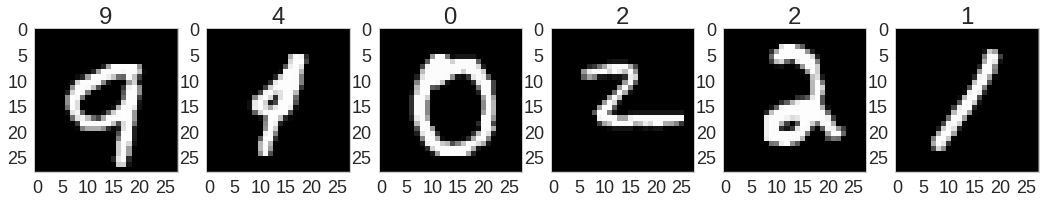

In [8]:
n = 6
plt.figure(figsize=(3*n,3))
for i in range(n):
    plt.subplot(1,n,i+1)
    idx = np.random.randint(0, len(mnist_trn_data))
    plt.imshow(mnist_trn_data[idx,0,:,:], cmap='gray', interpolation='None')
    plt.grid('off')
    plt.title(mnist_trn_label[idx])

### Some helpful functions

In [9]:
def print_lasagne_net(_net, skipnoparam=True):
    '''
    Print a summary of the layer and their parameter shapes
    '''
    layers = L.get_all_layers(_net)
    for l in layers:
        out = l.output_shape
        par = l.get_params()
        if skipnoparam and len(par)==0 and l.name==None:
            continue
        print "Layer\t: %s\nName\t: %s\nType\t: %s" % (l, l.name, type(l))
        print "Shape\t: %s" % (out,)
        if len(par)>0:
            print "Params"
            for p in par:
                print "        |-- {:<10}: {:}".format(p.name, p.get_value().shape,)
        print "\n"

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    '''
    for a given 4d input image tensor and a 2d target tensor of one-hot embedding, 
    return a shuffled batch of input-target pair
    '''
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
          
def embedding(x, c=10): 
    '''
    Also known as one-hot embedding.
    '''
    y = np.zeros((len(x), c), dtype=fpX)
    y[np.arange(len(x)), x] = 1
    return y

# Step 1) Define the classifier net
## Reminder:
The dense layer (fully connected layer) performs $Y = XW + b$ on its (flattened) input $X$ of shape (\# of samples, # of features).

A rectifier nonlinearity, applied after the linear transformation in some cases, is the piece-wise function $\phi(x)=\text{max}(0, x)$ applied element-wise.

A sigmoid nonlinearity, applied after the linear transformation in some cases, is the function $\sigma(x)=\frac{1}{1+\exp(-x)}$ applied element-wise, which outputs number between 0 and 1.

A tanh nonlinearity, applied after the linear transformation in some cases, is the function $tanh(x) = \frac{1-\exp(-2x)}{1+\exp(-2x)}$ applied element-wise, which outputs number between -1 and 1.

In [10]:
npc = 1         # # of channels in image
npx = 28        # # of pixels width/height of images
ny = 10         # # of classes

In [74]:
def model_1(__X):
    '''
    A single linear layer
    '''
    _input = L.InputLayer((None, npc, npx, npx), input_var=__X, name='X')
    _fc1 = L.DenseLayer(_input, ny, W=I.Constant(0.0), b=I.Constant(0.), nonlinearity=None) 
    return _fc1


def model_2(__X): 
    '''
    Multilayer perceptron (rectify nonlinearity) with one nonlinear layer and one final linear classifer layer.
    '''
    _input = L.InputLayer((None, npc, npx, npx), input_var=__X, name='X')
    _fc1 = L.DenseLayer(_input, 2048, W=I.Normal(0.002), b=I.Constant(0.), nonlinearity=NL.rectify)
    _fc2 = L.DenseLayer(_fc1, ny, W=I.Normal(0.02), b=I.Constant(0.), nonlinearity=None)
    return _fc2

In [90]:
_X = T.tensor4() # a theano variable representing the input data
_Y = T.matrix()  # a theano variable representing the class label

_cls = model_2(_X)

# Look at the details of the network input, output and filter shapes
print_lasagne_net(_cls, skipnoparam=True)

cls_params = L.get_all_params(_cls, trainable=True)
print cls_params

Layer	: <lasagne.layers.input.InputLayer object at 0x7fc32bc75710>
Name	: X
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 1, 28, 28)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7fc32bc75cd0>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 2048)
Params
        |-- W         : (784, 2048)
        |-- b         : (2048,)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7fc32bc75090>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 10)
Params
        |-- W         : (2048, 10)
        |-- b         : (10,)


[W, b, W, b]


# Step 2) Define the loss function and compile the theano expressions

In [91]:
def loss(__y_bar, __y):
    '''The loss function used to train the network -- tells what is good and what is bad'''
    return O.squared_error(__y_bar, __y).mean()

### The following block of code compiles our training expressions. The important part are the functions that results:
cls_trn_fn(X, Y): The classifier training function. It takes a batch of sample data point and labels as input and performs gradient descent on the parameters (all of them!) of our network. It returns the loss and accuracy on that batch.

cls_val_fn(X, Y): The classifier validation function. It takes a batch of sample data point and labels as input and returns the loss and accuracy on that batch.

cls_pred_fn(X): For a batch of sample data point, return the predicted label i.e. the one corresponding to the maximum network output value.

In [92]:
_lr = theano.shared(fpX(0))
_l2 = theano.shared(fpX(0))

_cls_reg = _l2 * R.regularize_layer_params(_cls, R.l2) # regularization loss
_cls_trn_pred = L.get_output(_cls, deterministic=False) # training prediction
_cls_trn_loss = loss(_cls_trn_pred, _Y) + _cls_reg # total training loss
_cls_trn_acc = T.mean(T.eq(T.argmax(_cls_trn_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_cls_val_pred = L.get_output(_cls, deterministic=True) #validation prediction
_cls_val_loss = loss(_cls_val_pred, _Y) + _cls_reg # total validation loss
_cls_val_acc = T.mean(T.eq(T.argmax(_cls_val_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_class = T.argmax(_cls_val_pred, axis=1)

cls_updates = lasagne.updates.sgd(_cls_trn_loss, cls_params, learning_rate=_lr) 
cls_updates = lasagne.updates.apply_momentum(cls_updates, cls_params, momentum=0.9)

print 'COMPILING'
t = time.time()
cls_trn_fn = theano.function([_X, _Y], [_cls_trn_loss, _cls_trn_acc], updates=cls_updates)
cls_val_fn = theano.function([_X, _Y], [_cls_val_loss, _cls_val_acc])
cls_pred_fn = theano.function([_X], _class)
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
0.80 seconds to compile theano functions


# Step 3 & 4) Training and validating the model. 

-Note that the parameter initialization, which is very important for training success, was defined when we defined the network and the values were initialized at compilation time.

-We decrease learning rate by 'perc_decay'% every epoch after 'niter' epoch at initial rate 'lr'. This is to "fine tune" the learning process toward the end, and is known as learning rate decay.

-We record the history of the training and validation accuracies.

In [93]:
lr = 2.   # initial learning rate for sgd
l2 = 0.    # l2 weight decay
niter = 100        # # of iter at starting learning rate
perc_decay = 5.0 # # of iter to linearly decay learning rate to zero
num_epochs = 100
batch_size = 1000
max_trn_size = 60000

_lr.set_value(fpX(lr))
_l2.set_value(fpX(l2))

mnist_trn_emb_label = embedding(mnist_trn_label, ny)
mnist_val_emb_label = embedding(mnist_val_label, ny)

trn_hist = []
val_hist = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    trn_err = 0
    trn_acc = 0
    trn_batches = 0
    start_time = time.time()
    for xb, yb in tqdm(iterate_minibatches(mnist_trn_data[:max_trn_size], mnist_trn_emb_label[:max_trn_size], batch_size, shuffle=False)):
        _, _ = cls_trn_fn(xb, yb)
    
    for xb, yb in iterate_minibatches(mnist_trn_data[:max_trn_size], mnist_trn_emb_label[:max_trn_size], batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        trn_err += err
        trn_acc += acc
        trn_batches += 1
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for xb, yb in iterate_minibatches(mnist_val_data, mnist_val_emb_label, batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        val_err += err
        val_acc += acc
        val_batches += 1

    trn_hist += [trn_acc / trn_batches,]
    val_hist += [val_acc / val_batches,]
    # Then we print the results for this epoch:
    print("\n  Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:       {:.6f}".format(trn_err / trn_batches))
    print("  training accuracy:   {:.2f} %".format(trn_acc / trn_batches * 100))
    print("  validation loss:     {:.6f}".format(val_err / val_batches))
    print("  validation accuracy: {:.2f} %".format(val_acc / val_batches * 100))
    
    if epoch > niter:
        _lr.set_value(fpX(_lr.get_value() * (1.0 - perc_decay / 100.0)))     
    sys.stdout.flush()

60it [00:00, 164.78it/s]


  Epoch 1 of 100 took 0.640s
  training loss:       0.033677
  training accuracy:   86.69 %
  validation loss:     0.034110
  validation accuracy: 86.57 %



60it [00:00, 162.96it/s]


  Epoch 2 of 100 took 0.625s
  training loss:       0.021471
  training accuracy:   90.75 %
  validation loss:     0.021966
  validation accuracy: 90.45 %



60it [00:00, 151.58it/s]


  Epoch 3 of 100 took 0.602s
  training loss:       0.017724
  training accuracy:   92.44 %
  validation loss:     0.018265
  validation accuracy: 92.21 %



60it [00:00, 153.04it/s]


  Epoch 4 of 100 took 0.617s
  training loss:       0.015807
  training accuracy:   93.38 %
  validation loss:     0.016363
  validation accuracy: 93.31 %



60it [00:00, 167.60it/s]


  Epoch 5 of 100 took 0.560s
  training loss:       0.014480
  training accuracy:   94.14 %
  validation loss:     0.015059
  validation accuracy: 94.08 %



60it [00:00, 170.81it/s]


  Epoch 6 of 100 took 0.567s
  training loss:       0.013432
  training accuracy:   94.74 %
  validation loss:     0.014042
  validation accuracy: 94.62 %



60it [00:00, 153.21it/s]


  Epoch 7 of 100 took 0.601s
  training loss:       0.012575
  training accuracy:   95.31 %
  validation loss:     0.013220
  validation accuracy: 95.06 %



60it [00:00, 158.20it/s]


  Epoch 8 of 100 took 0.596s
  training loss:       0.011855
  training accuracy:   95.68 %
  validation loss:     0.012539
  validation accuracy: 95.39 %



60it [00:00, 170.62it/s]


  Epoch 9 of 100 took 0.549s
  training loss:       0.011232
  training accuracy:   96.00 %
  validation loss:     0.011954
  validation accuracy: 95.71 %



60it [00:00, 147.60it/s]


  Epoch 10 of 100 took 0.617s
  training loss:       0.010695
  training accuracy:   96.33 %
  validation loss:     0.011449
  validation accuracy: 95.94 %



60it [00:00, 152.64it/s]


  Epoch 11 of 100 took 0.619s
  training loss:       0.010238
  training accuracy:   96.59 %
  validation loss:     0.011019
  validation accuracy: 96.04 %



60it [00:00, 167.73it/s]


  Epoch 12 of 100 took 0.569s
  training loss:       0.009857
  training accuracy:   96.85 %
  validation loss:     0.010668
  validation accuracy: 96.20 %



60it [00:00, 152.44it/s]


  Epoch 13 of 100 took 0.616s
  training loss:       0.009519
  training accuracy:   97.01 %
  validation loss:     0.010359
  validation accuracy: 96.31 %



60it [00:00, 170.67it/s]


  Epoch 14 of 100 took 0.549s
  training loss:       0.009205
  training accuracy:   97.16 %
  validation loss:     0.010075
  validation accuracy: 96.50 %



60it [00:00, 137.84it/s]


  Epoch 15 of 100 took 0.654s
  training loss:       0.008914
  training accuracy:   97.30 %
  validation loss:     0.009816
  validation accuracy: 96.63 %



60it [00:00, 167.88it/s]


  Epoch 16 of 100 took 0.568s
  training loss:       0.008655
  training accuracy:   97.40 %
  validation loss:     0.009589
  validation accuracy: 96.73 %



60it [00:00, 159.68it/s]


  Epoch 17 of 100 took 0.580s
  training loss:       0.008398
  training accuracy:   97.53 %
  validation loss:     0.009365
  validation accuracy: 96.89 %



60it [00:00, 171.72it/s]


  Epoch 18 of 100 took 0.564s
  training loss:       0.008133
  training accuracy:   97.61 %
  validation loss:     0.009130
  validation accuracy: 97.02 %



60it [00:00, 174.94it/s]


  Epoch 19 of 100 took 0.540s
  training loss:       0.007873
  training accuracy:   97.72 %
  validation loss:     0.008896
  validation accuracy: 97.08 %



60it [00:00, 174.92it/s]


  Epoch 20 of 100 took 0.559s
  training loss:       0.007641
  training accuracy:   97.82 %
  validation loss:     0.008693
  validation accuracy: 97.17 %



60it [00:00, 173.68it/s]


  Epoch 21 of 100 took 0.545s
  training loss:       0.007444
  training accuracy:   97.89 %
  validation loss:     0.008525
  validation accuracy: 97.28 %



60it [00:00, 174.51it/s]


  Epoch 22 of 100 took 0.560s
  training loss:       0.007265
  training accuracy:   97.97 %
  validation loss:     0.008376
  validation accuracy: 97.36 %



60it [00:00, 174.31it/s]


  Epoch 23 of 100 took 0.542s
  training loss:       0.007091
  training accuracy:   98.06 %
  validation loss:     0.008230
  validation accuracy: 97.39 %



60it [00:00, 165.43it/s]


  Epoch 24 of 100 took 0.560s
  training loss:       0.006930
  training accuracy:   98.13 %
  validation loss:     0.008100
  validation accuracy: 97.43 %



60it [00:00, 174.55it/s]


  Epoch 25 of 100 took 0.541s
  training loss:       0.006783
  training accuracy:   98.19 %
  validation loss:     0.007981
  validation accuracy: 97.49 %



60it [00:00, 161.32it/s]


  Epoch 26 of 100 took 0.570s
  training loss:       0.006649
  training accuracy:   98.25 %
  validation loss:     0.007876
  validation accuracy: 97.50 %



60it [00:00, 175.16it/s]


  Epoch 27 of 100 took 0.539s
  training loss:       0.006528
  training accuracy:   98.29 %
  validation loss:     0.007780
  validation accuracy: 97.50 %



60it [00:00, 165.58it/s]


  Epoch 28 of 100 took 0.560s
  training loss:       0.006415
  training accuracy:   98.35 %
  validation loss:     0.007693
  validation accuracy: 97.51 %



60it [00:00, 174.58it/s]


  Epoch 29 of 100 took 0.541s
  training loss:       0.006308
  training accuracy:   98.39 %
  validation loss:     0.007610
  validation accuracy: 97.55 %



60it [00:00, 165.24it/s]


  Epoch 30 of 100 took 0.563s
  training loss:       0.006202
  training accuracy:   98.44 %
  validation loss:     0.007527
  validation accuracy: 97.58 %



60it [00:00, 174.96it/s]


  Epoch 31 of 100 took 0.559s
  training loss:       0.006099
  training accuracy:   98.47 %
  validation loss:     0.007449
  validation accuracy: 97.62 %



60it [00:00, 174.71it/s]


  Epoch 32 of 100 took 0.541s
  training loss:       0.006001
  training accuracy:   98.51 %
  validation loss:     0.007375
  validation accuracy: 97.66 %



60it [00:00, 174.69it/s]


  Epoch 33 of 100 took 0.559s
  training loss:       0.005903
  training accuracy:   98.55 %
  validation loss:     0.007301
  validation accuracy: 97.68 %



60it [00:00, 174.66it/s]


  Epoch 34 of 100 took 0.540s
  training loss:       0.005811
  training accuracy:   98.59 %
  validation loss:     0.007235
  validation accuracy: 97.74 %



60it [00:00, 174.71it/s]


  Epoch 35 of 100 took 0.560s
  training loss:       0.005730
  training accuracy:   98.64 %
  validation loss:     0.007177
  validation accuracy: 97.77 %



60it [00:00, 174.60it/s]


  Epoch 36 of 100 took 0.541s
  training loss:       0.005661
  training accuracy:   98.68 %
  validation loss:     0.007132
  validation accuracy: 97.80 %



60it [00:00, 164.85it/s]


  Epoch 37 of 100 took 0.562s
  training loss:       0.005597
  training accuracy:   98.72 %
  validation loss:     0.007090
  validation accuracy: 97.80 %



60it [00:00, 171.26it/s]


  Epoch 38 of 100 took 0.555s
  training loss:       0.005540
  training accuracy:   98.75 %
  validation loss:     0.007055
  validation accuracy: 97.82 %



60it [00:00, 163.55it/s]


  Epoch 39 of 100 took 0.571s
  training loss:       0.005481
  training accuracy:   98.78 %
  validation loss:     0.007019
  validation accuracy: 97.82 %



60it [00:00, 174.57it/s]


  Epoch 40 of 100 took 0.549s
  training loss:       0.005420
  training accuracy:   98.81 %
  validation loss:     0.006980
  validation accuracy: 97.86 %



60it [00:00, 165.65it/s]


  Epoch 41 of 100 took 0.559s
  training loss:       0.005353
  training accuracy:   98.84 %
  validation loss:     0.006934
  validation accuracy: 97.86 %



60it [00:00, 174.91it/s]


  Epoch 42 of 100 took 0.542s
  training loss:       0.005281
  training accuracy:   98.87 %
  validation loss:     0.006883
  validation accuracy: 97.87 %



60it [00:00, 151.77it/s]


  Epoch 43 of 100 took 0.594s
  training loss:       0.005208
  training accuracy:   98.89 %
  validation loss:     0.006832
  validation accuracy: 97.87 %



60it [00:00, 174.35it/s]


  Epoch 44 of 100 took 0.664s
  training loss:       0.005141
  training accuracy:   98.92 %
  validation loss:     0.006786
  validation accuracy: 97.88 %



60it [00:00, 166.84it/s]


  Epoch 45 of 100 took 0.566s
  training loss:       0.005074
  training accuracy:   98.94 %
  validation loss:     0.006740
  validation accuracy: 97.87 %



60it [00:00, 160.43it/s]


  Epoch 46 of 100 took 0.581s
  training loss:       0.005007
  training accuracy:   98.95 %
  validation loss:     0.006695
  validation accuracy: 97.86 %



60it [00:00, 168.28it/s]


  Epoch 47 of 100 took 0.600s
  training loss:       0.004934
  training accuracy:   98.98 %
  validation loss:     0.006643
  validation accuracy: 97.90 %



60it [00:00, 158.48it/s]


  Epoch 48 of 100 took 0.586s
  training loss:       0.004857
  training accuracy:   99.01 %
  validation loss:     0.006586
  validation accuracy: 97.91 %



60it [00:00, 169.55it/s]


  Epoch 49 of 100 took 0.583s
  training loss:       0.004790
  training accuracy:   99.02 %
  validation loss:     0.006538
  validation accuracy: 97.91 %



60it [00:00, 161.92it/s]


  Epoch 50 of 100 took 0.577s
  training loss:       0.004723
  training accuracy:   99.05 %
  validation loss:     0.006490
  validation accuracy: 97.91 %



60it [00:00, 138.14it/s]


  Epoch 51 of 100 took 0.649s
  training loss:       0.004659
  training accuracy:   99.08 %
  validation loss:     0.006445
  validation accuracy: 97.94 %



60it [00:00, 168.79it/s]


  Epoch 52 of 100 took 0.562s
  training loss:       0.004597
  training accuracy:   99.10 %
  validation loss:     0.006401
  validation accuracy: 97.97 %



60it [00:00, 163.70it/s]


  Epoch 53 of 100 took 0.564s
  training loss:       0.004542
  training accuracy:   99.12 %
  validation loss:     0.006365
  validation accuracy: 97.97 %



60it [00:00, 174.28it/s]


  Epoch 54 of 100 took 0.542s
  training loss:       0.004488
  training accuracy:   99.14 %
  validation loss:     0.006329
  validation accuracy: 97.98 %



60it [00:00, 148.74it/s]


  Epoch 55 of 100 took 0.601s
  training loss:       0.004436
  training accuracy:   99.16 %
  validation loss:     0.006295
  validation accuracy: 98.01 %



60it [00:00, 174.06it/s]


  Epoch 56 of 100 took 0.542s
  training loss:       0.004381
  training accuracy:   99.19 %
  validation loss:     0.006260
  validation accuracy: 98.00 %



60it [00:00, 143.37it/s]


  Epoch 57 of 100 took 0.619s
  training loss:       0.004329
  training accuracy:   99.20 %
  validation loss:     0.006226
  validation accuracy: 98.04 %



60it [00:00, 173.39it/s]


  Epoch 58 of 100 took 0.578s
  training loss:       0.004287
  training accuracy:   99.22 %
  validation loss:     0.006203
  validation accuracy: 98.04 %



60it [00:00, 171.99it/s]


  Epoch 59 of 100 took 0.549s
  training loss:       0.004237
  training accuracy:   99.24 %
  validation loss:     0.006172
  validation accuracy: 98.05 %



60it [00:00, 150.02it/s]


  Epoch 60 of 100 took 0.619s
  training loss:       0.004192
  training accuracy:   99.26 %
  validation loss:     0.006146
  validation accuracy: 98.06 %



60it [00:00, 168.57it/s]


  Epoch 61 of 100 took 0.563s
  training loss:       0.004152
  training accuracy:   99.27 %
  validation loss:     0.006123
  validation accuracy: 98.07 %



60it [00:00, 161.81it/s]


  Epoch 62 of 100 took 0.572s
  training loss:       0.004116
  training accuracy:   99.29 %
  validation loss:     0.006105
  validation accuracy: 98.09 %



60it [00:00, 173.69it/s]


  Epoch 63 of 100 took 0.544s
  training loss:       0.004079
  training accuracy:   99.31 %
  validation loss:     0.006086
  validation accuracy: 98.10 %



60it [00:00, 135.89it/s]


  Epoch 64 of 100 took 0.661s
  training loss:       0.004049
  training accuracy:   99.33 %
  validation loss:     0.006074
  validation accuracy: 98.11 %



60it [00:00, 168.15it/s]


  Epoch 65 of 100 took 0.632s
  training loss:       0.004013
  training accuracy:   99.34 %
  validation loss:     0.006056
  validation accuracy: 98.11 %



60it [00:00, 162.29it/s]


  Epoch 66 of 100 took 0.580s
  training loss:       0.003980
  training accuracy:   99.34 %
  validation loss:     0.006040
  validation accuracy: 98.11 %



60it [00:00, 160.13it/s]


  Epoch 67 of 100 took 0.576s
  training loss:       0.003940
  training accuracy:   99.36 %
  validation loss:     0.006017
  validation accuracy: 98.11 %



60it [00:00, 172.64it/s]


  Epoch 68 of 100 took 0.552s
  training loss:       0.003928
  training accuracy:   99.37 %
  validation loss:     0.006022
  validation accuracy: 98.11 %



60it [00:00, 166.29it/s]


  Epoch 69 of 100 took 0.560s
  training loss:       0.003900
  training accuracy:   99.38 %
  validation loss:     0.006012
  validation accuracy: 98.11 %



60it [00:00, 172.77it/s]


  Epoch 70 of 100 took 0.547s
  training loss:       0.003853
  training accuracy:   99.41 %
  validation loss:     0.005983
  validation accuracy: 98.11 %



60it [00:00, 164.38it/s]


  Epoch 71 of 100 took 0.564s
  training loss:       0.003786
  training accuracy:   99.42 %
  validation loss:     0.005934
  validation accuracy: 98.14 %



60it [00:00, 172.95it/s]


  Epoch 72 of 100 took 0.561s
  training loss:       0.003742
  training accuracy:   99.42 %
  validation loss:     0.005907
  validation accuracy: 98.16 %



60it [00:00, 159.65it/s]


  Epoch 73 of 100 took 0.586s
  training loss:       0.003732
  training accuracy:   99.42 %
  validation loss:     0.005912
  validation accuracy: 98.16 %



60it [00:00, 168.45it/s]


  Epoch 74 of 100 took 0.574s
  training loss:       0.003874
  training accuracy:   99.43 %
  validation loss:     0.006058
  validation accuracy: 98.15 %



60it [00:00, 173.54it/s]


  Epoch 75 of 100 took 0.544s
  training loss:       0.003806
  training accuracy:   99.43 %
  validation loss:     0.006007
  validation accuracy: 98.19 %



60it [00:00, 151.16it/s]


  Epoch 76 of 100 took 0.600s
  training loss:       0.003739
  training accuracy:   99.46 %
  validation loss:     0.005929
  validation accuracy: 98.15 %



60it [00:00, 173.67it/s]


  Epoch 77 of 100 took 0.543s
  training loss:       0.003692
  training accuracy:   99.48 %
  validation loss:     0.005915
  validation accuracy: 98.15 %



60it [00:00, 163.96it/s]


  Epoch 78 of 100 took 0.565s
  training loss:       0.003675
  training accuracy:   99.49 %
  validation loss:     0.005916
  validation accuracy: 98.15 %



60it [00:00, 173.83it/s]


  Epoch 79 of 100 took 0.543s
  training loss:       0.003640
  training accuracy:   99.50 %
  validation loss:     0.005899
  validation accuracy: 98.17 %



60it [00:00, 149.40it/s]


  Epoch 80 of 100 took 0.609s
  training loss:       0.003607
  training accuracy:   99.50 %
  validation loss:     0.005884
  validation accuracy: 98.18 %



60it [00:00, 167.98it/s]


  Epoch 81 of 100 took 0.584s
  training loss:       0.003577
  training accuracy:   99.51 %
  validation loss:     0.005870
  validation accuracy: 98.18 %



60it [00:00, 174.10it/s]


  Epoch 82 of 100 took 0.543s
  training loss:       0.003548
  training accuracy:   99.51 %
  validation loss:     0.005856
  validation accuracy: 98.18 %



60it [00:00, 173.68it/s]


  Epoch 83 of 100 took 0.561s
  training loss:       0.003511
  training accuracy:   99.51 %
  validation loss:     0.005836
  validation accuracy: 98.18 %



60it [00:00, 174.11it/s]


  Epoch 84 of 100 took 0.543s
  training loss:       0.003489
  training accuracy:   99.52 %
  validation loss:     0.005829
  validation accuracy: 98.18 %



60it [00:00, 163.50it/s]


  Epoch 85 of 100 took 0.620s
  training loss:       0.003457
  training accuracy:   99.52 %
  validation loss:     0.005814
  validation accuracy: 98.20 %



60it [00:00, 168.09it/s]


  Epoch 86 of 100 took 0.565s
  training loss:       0.003439
  training accuracy:   99.54 %
  validation loss:     0.005811
  validation accuracy: 98.20 %



60it [00:00, 137.79it/s]


  Epoch 87 of 100 took 0.646s
  training loss:       0.003404
  training accuracy:   99.55 %
  validation loss:     0.005793
  validation accuracy: 98.21 %



60it [00:00, 165.35it/s]


  Epoch 88 of 100 took 0.592s
  training loss:       0.003379
  training accuracy:   99.55 %
  validation loss:     0.005783
  validation accuracy: 98.23 %



60it [00:00, 149.75it/s]


  Epoch 89 of 100 took 0.608s
  training loss:       0.003357
  training accuracy:   99.56 %
  validation loss:     0.005776
  validation accuracy: 98.25 %



60it [00:00, 168.68it/s]


  Epoch 90 of 100 took 0.598s
  training loss:       0.003334
  training accuracy:   99.57 %
  validation loss:     0.005768
  validation accuracy: 98.23 %



60it [00:00, 168.64it/s]


  Epoch 91 of 100 took 0.563s
  training loss:       0.003307
  training accuracy:   99.58 %
  validation loss:     0.005755
  validation accuracy: 98.24 %



60it [00:00, 152.84it/s]


  Epoch 92 of 100 took 0.600s
  training loss:       0.003286
  training accuracy:   99.59 %
  validation loss:     0.005749
  validation accuracy: 98.24 %



60it [00:00, 150.59it/s]


  Epoch 93 of 100 took 0.604s
  training loss:       0.003264
  training accuracy:   99.59 %
  validation loss:     0.005741
  validation accuracy: 98.26 %



60it [00:00, 159.80it/s]


  Epoch 94 of 100 took 0.582s
  training loss:       0.003253
  training accuracy:   99.60 %
  validation loss:     0.005744
  validation accuracy: 98.28 %



60it [00:00, 173.20it/s]


  Epoch 95 of 100 took 0.579s
  training loss:       0.003228
  training accuracy:   99.61 %
  validation loss:     0.005732
  validation accuracy: 98.28 %



60it [00:00, 153.43it/s]


  Epoch 96 of 100 took 0.598s
  training loss:       0.003212
  training accuracy:   99.62 %
  validation loss:     0.005730
  validation accuracy: 98.29 %



60it [00:00, 168.62it/s]


  Epoch 97 of 100 took 0.577s
  training loss:       0.003208
  training accuracy:   99.63 %
  validation loss:     0.005737
  validation accuracy: 98.28 %



60it [00:00, 173.43it/s]


  Epoch 98 of 100 took 0.543s
  training loss:       0.003290
  training accuracy:   99.63 %
  validation loss:     0.005830
  validation accuracy: 98.26 %



60it [00:00, 141.09it/s]


  Epoch 99 of 100 took 0.634s
  training loss:       0.003324
  training accuracy:   99.63 %
  validation loss:     0.005877
  validation accuracy: 98.29 %



60it [00:00, 167.35it/s]


  Epoch 100 of 100 took 0.559s
  training loss:       0.003102
  training accuracy:   99.64 %
  validation loss:     0.005669
  validation accuracy: 98.27 %


## Plot the history of training and validation accuracies

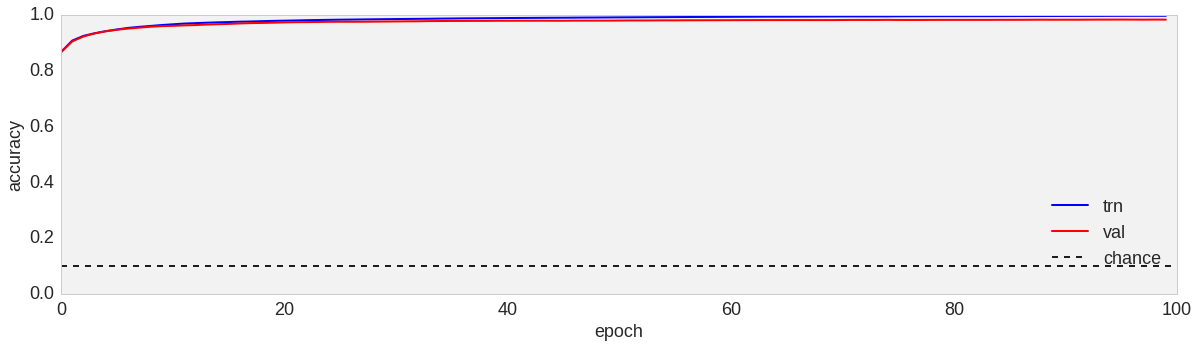

In [94]:
plt.figure(figsize=(20,5))
plt.plot(trn_hist, 'b', label='trn', lw=2)
plt.plot(val_hist, 'r', label='val', lw=2)
plt.axhline(1./ny, color='k', linestyle='--', label='chance')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0., 1.0)
plt.legend(bbox_to_anchor=(1., 0.4))
plt.grid()

## What to do if training fails?
### Right now, we are doing training without most of the modern bells and whistles like momentum, dropout and other learning algorithms based on gradient descent that are more suitable for the problems at hand. But even with the basic toolbox, there is quite a lot we can do when training initially fails:
1) Try different values of the learning rate: sometimes a value too low is as bad as a value that is too high

2) Try changing the initial conditions. Sometimes its better to start at zero but certain nonlinearity will return singular results at this point, so it's not always an option.

3) Try to change the batch size. The batch size adds some randomness to the gradient evaluation. A gradient that is close to zero in one batch may be large in another. However, if the batch size is too large it "evens out" the gradient which means it may be stuck for good for all batch in a local minimum. However, batches too small incur a cost in effectiveness of the algorithm and may not work well with more modern technique like batch-normalization.

4) Play with the architecture.

5) Detect failure early. This is why it is important to monitor the output of the network. One can ususally tell very quickly if things are working or not.

6) Try adding momentum to the gradient descent if the validation accuracy seems stuck at a low value.

## Show an example case of the confusion matrix. What digits are most likely to be confused? Show some instance of this confusion.

In [96]:
C = np.zeros(shape=(ny,ny))
for xb, yb in iterate_minibatches(mnist_val_data, mnist_val_label, batch_size, shuffle=False):
    ypb  = cls_pred_fn(xb)
    yeb  = embedding(yb, ny)
    yebp = embedding(ypb, ny)

    C += np.dot(yeb.T, yebp)

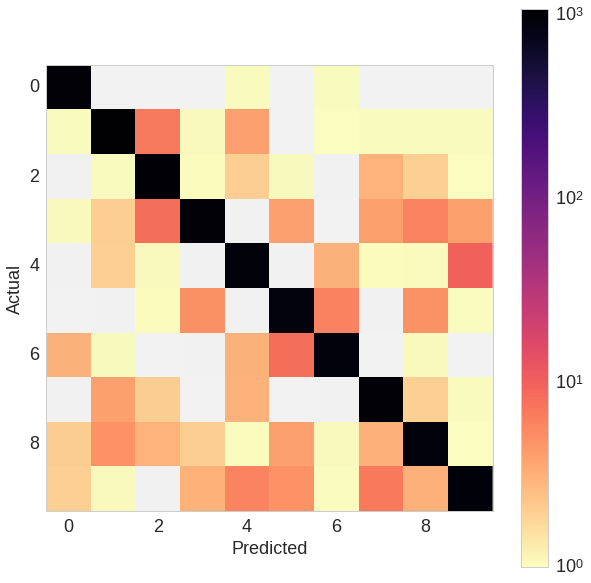

In [97]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(10,10))
plt.imshow(C, cmap=cm.magma_r, norm=LogNorm(vmin=1, vmax=np.amax(C)), interpolation='None')
plt.colorbar()
plt.grid('off')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [49]:
print "Overall classification accuracy = %.1f%%" % (np.trace(C, dtype=fpX) * 100. / len(mnist_val_data))

Overall classification accuracy = 95.0%


## Get the learned parameter values

In [ ]:
# get the parameter values into numpy array
params = [p.get_value() for p in cls_params]
print params[0].shape

## Do something with the parameters...